In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from utils.plot_history import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8ib5ewto because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
# img = load_img('data/images/fire/0001.jpg', target_size=None, interpolation='nearest') # "nearest", "bilinear", and "bicubic"

In [3]:
# tf.keras.layers.experimental.preprocessing.RandomCrop(
#     height, width, seed=None, **kwargs
# )

In [4]:
# # preprocess numpy
# x /= 127.5
# x -= 1.

In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True) # TODO: save to host machine
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/tmp/.keras/datasets/flower_photos')

In [7]:
!ls /tmp/.keras/datasets/flower_photos

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


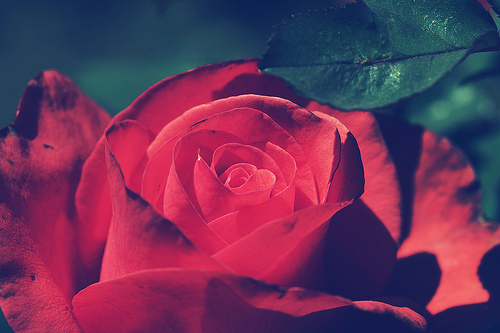

In [8]:
roses = list(data_dir.glob('roses/*'))
img = PIL.Image.open(str(roses[1]))
img

In [9]:
img_to_array(img).shape

(333, 500, 3)

In [10]:
batch_size = 32 # TODO: can't make this bigger
img_height = img_width = 200
normalization_layer = keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_dataset.class_names

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_class_names = validation_dataset.class_names

validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names, validation_class_names

(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

In [14]:
for xb,yb in train_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(32, 200, 200, 3) (32,) tf.Tensor(-0.2150336, shape=(), dtype=float32)


tf.Tensor(2, shape=(), dtype=int32) class_name: roses


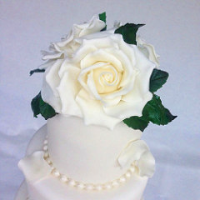

In [15]:
i = 15
print(yb[i], 'class_name:', class_names[yb[i]])
array_to_img(xb[i])

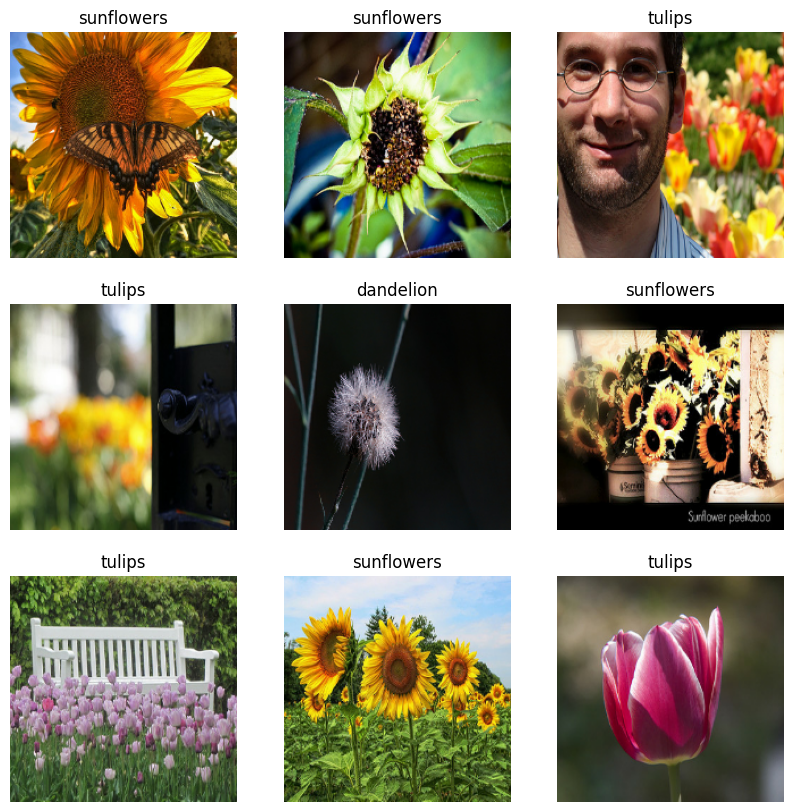

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        _img = (images[i].numpy() + 1.) * 127.5
        plt.imshow(_img.astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

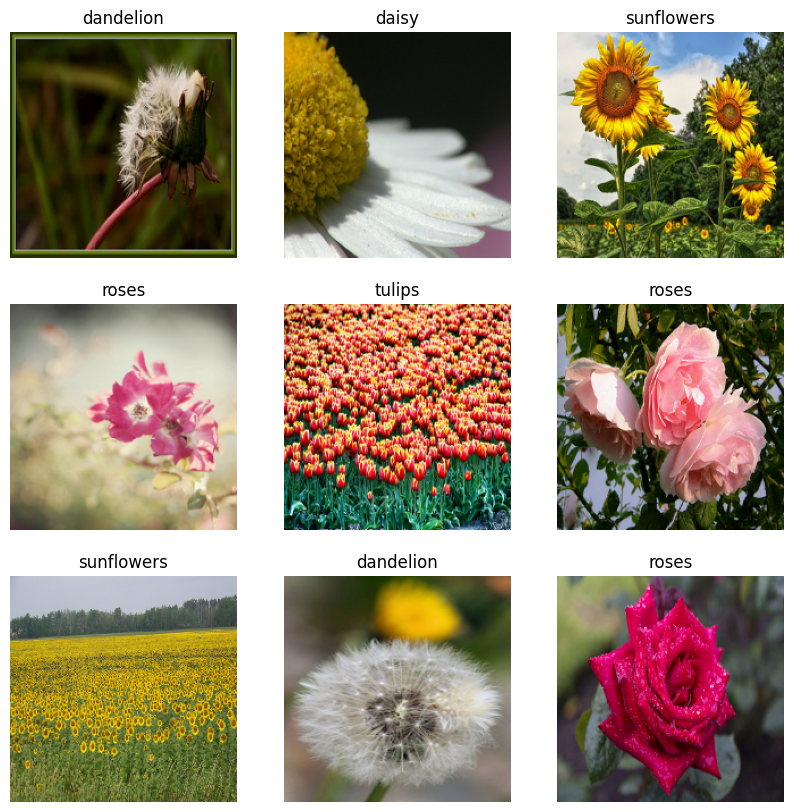

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        _img = (images[i].numpy() + 1.) * 127.5
        plt.imshow(_img.astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [18]:
# for xb,yb in validation_dataset:
#     print(xb.shape, yb.shape, tf.reduce_mean(xb))
#     break
# array_to_img(xb[0])

# TODO:

In [19]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.2),
#     ]
# )

In [20]:
# inputs = keras.Input(shape=(img_height, img_width, 3))
# # x = data_augmentation(inputs)
# x = inputs

# x = layers.Rescaling(1./255)(x)
# x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# for size in [32, 64, 128, 256, 512]:
#     residual = x

#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

#     x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#     residual = layers.Conv2D(
#         size, 1, strides=2, padding="same", use_bias=False)(residual)
#     x = layers.add([x, residual])

# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(len(class_names), activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=3)

Epoch 1/3
92/92 [==============================] - 6s 40ms/step - loss: 1.6047 - accuracy: 0.2418 - val_loss: 1.6044 - val_accuracy: 0.2398
Epoch 2/3
92/92 [==============================] - 3s 28ms/step - loss: 1.6024 - accuracy: 0.2459 - val_loss: 1.6027 - val_accuracy: 0.2398
Epoch 3/3
92/92 [==============================] - 3s 28ms/step - loss: 1.6015 - accuracy: 0.2459 - val_loss: 1.6026 - val_accuracy: 0.2398


In [ ]:
# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer="rmsprop",
#               metrics=["accuracy"])
# history = model.fit(
#     train_dataset,
#     epochs=5,
#     validation_data=validation_dataset
# )

In [ ]:
plot_history(history)